# Features and Params

## Library Imports

In [1]:
# Necessary code to import our helper functions
import sys
sys.path.append("../..")

In [2]:
# Library imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from Common_Functions import add_unique_identifier, data_cleaning, hospital_data_agg

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def data_split(data, count_col_name = 'priv_count', count_thresh = 50):
    """
    This function splits the data into model set and future set. Model set is the data used to train, evaluate
    test the model. Future data is what the model needs to predict on.
    
    Args:
    data (pandas: DataFrame) - a pandas data frame with at least 3 columns - "priv_pay_mean", "priv_pay_median" and count_col_name
    count_col_name (str) - name of the column which is thresholded to make the split
    count_thresh (int) - threshold value used to split data on count_col_name
    
    Returns:
    model_data (pandas: DataFrame) - data frame with observations that will be used to train and test model
    future_data (pandas: DataFrame) - data frame with all observations on which model will make predictions
    """
    data = data[(data['priv_pay_median'] > 0) | (data['priv_pay_median'].isnull())]
    future_data = data[(data[count_col_name] <= count_thresh) | (data[count_col_name].isnull())]
    model_data = data[data[count_col_name] > count_thresh]
    model_data = model_data[model_data.priv_pay_median.notnull()]
    return model_data, future_data

## Data Import

In [4]:
data = pd.read_csv("../../Feature Matrix/processed_data.csv")

## Model Parameters

In [5]:
COUNT_THRESH = 34
RDM_SEED = 123
TRAIN_TEST_PROPORTION = 0.8

## Data Transformation

### One-Hot Categorical Encoding and Dropping NAs

In [6]:
data.drop(columns = ['CBSA_NAME'], inplace=True)
data = data_cleaning(data)

### Data Split

In [7]:
working_set, predict_set = data_split(data, count_thresh = COUNT_THRESH)

In [8]:
model_data = working_set
predict_data = predict_set

In [9]:
display(model_data)

,Unnamed: 0,year,site,priv_count,priv_pay_median,mcare_los,mcare_pay_median,lon,lat,Hospitals,...,group_revision_tha,group_revision_tka,group_robotic_assisted_surgery,group_rtc_slap_bank,group_septoplasty,group_tha,group_thoracic,group_tka,group_tpa,group_tsa
40,40,2018,1,63,24289.900,2.549296,8794.190,-96.920913,32.707875,114.0,...,0,0,0,0,0,0,0,0,0,0
70,70,2018,1,51,21408.000,3.543210,10395.160,-95.622552,29.598443,181.0,...,0,0,0,0,0,0,0,0,0,0
112,112,2018,1,64,29757.100,3.918699,14174.100,-74.005954,40.712776,143.0,...,0,0,0,0,0,0,0,0,0,0
219,219,2019,1,66,25240.905,3.241935,10144.445,-96.920913,32.707875,114.0,...,0,0,0,0,0,0,0,0,0,0
275,275,2019,1,45,34963.900,3.262295,14008.190,-74.005954,40.712776,143.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41969,41969,2019,0,55,8614.250,0.000000,6291.420,-83.079090,42.810540,30.0,...,0,0,0,0,0,0,0,0,0,0
41993,41993,2020,0,62,11590.770,0.000000,6628.030,-84.294090,34.075380,80.0,...,0,0,0,0,0,0,0,0,0,0
42065,42065,2020,0,39,20492.920,0.000000,7015.710,-95.622550,29.598440,181.0,...,0,0,0,0,0,0,0,0,0,0
42110,42110,2020,0,44,13777.100,0.000000,8517.130,-74.005950,40.712780,143.0,...,0,0,0,0,0,0,0,0,0,0


### Train / Test Split

In [10]:
X_input = model_data.drop(columns=["priv_pay_median"])
y_input = model_data["priv_pay_median"]

X_train, X_test, y_train, y_test = train_test_split(X_input,
                                                    y_input,
                                                    train_size = TRAIN_TEST_PROPORTION,
                                                    random_state = RDM_SEED)


### Monotonicity Contraint - Inpatient must be most expensive, all else equal

In [11]:
param_grid = {
    'learning_rate': [0.1,0.2,0.3,0.4],
    'gamma':[0, 0.01,0.1],
#     'min_child_weight':[0,1],
    'reg_lambda':[0,0.25,0.5,0.75,1,2]
}

In [12]:
mono = {'site': 1}
xgb_param_tuning_model = xgb.XGBRegressor(monotone_constraints = mono,
                                          n_estimators = 200,
                                          max_depth = 10,
#                                           gamma = 0,
                                          min_child_weight = 0,
#                                           learning_rate = 0.2,
#                                           reg_lambda = 0.5
                                         )

In [13]:
xgb_mono_model = GridSearchCV(xgb_param_tuning_model, param_grid, scoring='neg_mean_absolute_percentage_error')

xgb_mono_model.fit(X_train, y_train)

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=10, min_child_weight=0,
                                    missing=nan,
                                    monotone_constraints={'site': 1},
                                    n_est...ors=200, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             param_grid={'gamma': [0, 0.01, 0.1],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'reg_lambda': [0, 0.25, 0.5, 0.75, 1, 2]},
             scoring='neg_mean_absolute_percentage_error')

In [14]:
print(xgb_mono_model.cv_results_)
print(xgb_mono_model.best_params_)

{'mean_fit_time': array([1.72249002, 1.54399219, 1.48781667, 1.50336199, 1.59118385,
       1.50102243, 1.53746758, 1.37736492, 1.40386147, 1.44678097,
       1.5305222 , 1.41538119, 1.51126795, 1.44038081, 1.38828855,
       1.48200793, 1.5509223 , 1.49123425, 1.53943667, 1.46324358,
       1.47357898, 1.42345281, 1.43365731, 1.45662055, 1.77553792,
       1.46969438, 1.45788436, 1.51302352, 1.52110686, 1.44374185,
       1.60486536, 1.3976809 , 1.43557339, 1.43201103, 1.45839453,
       1.56737332, 1.70574751, 1.63474336, 1.61335964, 1.61030316,
       1.5449451 , 1.61559587, 1.56430049, 1.36671839, 1.43764544,
       1.47711415, 1.39140763, 1.4246572 , 1.72768211, 1.54577432,
       1.43938742, 1.41302876, 1.37733927, 1.54953699, 1.67090368,
       1.4928062 , 1.40603099, 1.40940642, 1.39332452, 1.42819328,
       1.77477565, 1.60405765, 1.69613829, 1.54451318, 1.57373734,
       1.5244597 , 1.67637768, 1.50920405, 1.70266771, 1.61529193,
       1.64526925, 1.6650589 ]), 'std_fit_ti

In [15]:
y_train_pred_xgb = xgb_mono_model.predict(X_train)
y_test_pred_xgb = xgb_mono_model.predict(X_test)

In [16]:
print(f"Monotonic XGBoost with Threshold >{COUNT_THRESH} claims for training set:")
print(f"Train MAPE: {mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred_xgb)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred_xgb)}\n")

Monotonic XGBoost with Threshold >34 claims for training set:
Train MAPE: 0.000603778330135928
Test MAPE: 0.1467598917919889



In [17]:
print(X_train.columns)

Index(['Unnamed: 0', 'year', 'site', 'priv_count', 'mcare_los',
       'mcare_pay_median', 'lon', 'lat', 'Hospitals', 'PctTeaching',
       'PctLargeHospital', 'PctPrivate', 'total_population', 'median_age',
       'sex_ratio', 'State_Poverty_Percent_All_Ages',
       'State_Median_Household_Income', 'income_pc', 'num_races',
       'household_size', 'frac_married', 'frac_school', 'frac_college',
       'frac_educated', 'annual_births', 'frac_veteran', 'frac_disability',
       'non_citizen', 'employment_rate', 'frac_priv_insurance',
       'frac_mcare_insurance', 'frac_no_insurance', 'cluster', 'mcare_count',
       'group_ankle_fix', 'group_ant_cerv_fusion', 'group_ant_tls_fusion',
       'group_bariatric', 'group_breast reconstruction', 'group_bsp',
       'group_bunionectomy', 'group_cardiac ablation',
       'group_cardiac ablation_additional_discrete',
       'group_cardiac ablation_linear_focal',
       'group_cardiac_ablaton_anesthesia', 'group_cardiac_ablaton_ice',
       'gro

ValueError: x and y must have same first dimension, but have shapes (13,) and (72,)

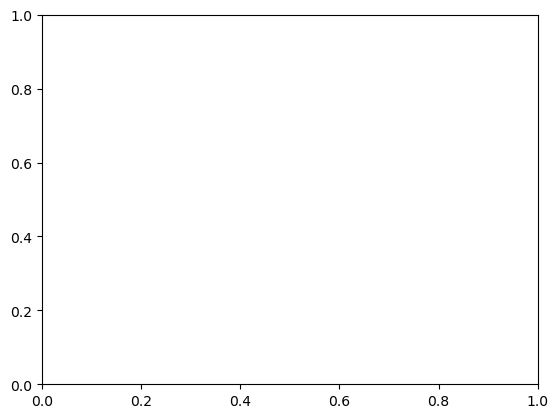

In [18]:
plt.plot([50,80,90,100,110,120,130,140,150,175,200,225,250], -xgb_mono_model.cv_results_['mean_test_score']*100)